This demonstration shows you how to work with [indexed
image](https://en.wikipedia.org/wiki/Indexed_color) using
[IndirectArrays.jl](https://github.com/JuliaArrays/IndirectArrays.jl)

An indexed image consists of two parts: the indices and the palatte. The palatte keeps track of
all possible pixel values of an image, while the `indices` consists of the palatte index of each
pixel.

In [1]:
using Images

The following is a normally used representation of image, i.e., an image as an array of
`Colorant`s.

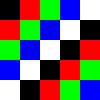

In [2]:
img = [
    RGB(0.0, 0.0, 0.0) RGB(1.0, 0.0, 0.0) RGB(0.0, 1.0, 0.0) RGB(0.0, 0.0, 1.0) RGB(1.0, 1.0, 1.0)
    RGB(1.0, 0.0, 0.0) RGB(0.0, 1.0, 0.0) RGB(0.0, 0.0, 1.0) RGB(1.0, 1.0, 1.0) RGB(0.0, 0.0, 0.0)
    RGB(0.0, 1.0, 0.0) RGB(0.0, 0.0, 1.0) RGB(1.0, 1.0, 1.0) RGB(0.0, 0.0, 0.0) RGB(1.0, 0.0, 0.0)
    RGB(0.0, 0.0, 1.0) RGB(1.0, 1.0, 1.0) RGB(0.0, 0.0, 0.0) RGB(1.0, 0.0, 0.0) RGB(0.0, 1.0, 0.0)
    RGB(1.0, 1.0, 1.0) RGB(0.0, 0.0, 0.0) RGB(1.0, 0.0, 0.0) RGB(0.0, 1.0, 0.0) RGB(0.0, 0.0, 1.0)]

Alternatively, we could save it in the indexed image format:

In [3]:
indices = [1 2 3 4 5; 2 3 4 5 1; 3 4 5 1 2; 4 5 1 2 3; 5 1 2 3 4] # `i` records the pixel value `palatte[i]`
palatte = [RGB(0.0, 0.0, 0.0), RGB(1.0, 0.0, 0.0), RGB(0.0, 1.0, 0.0), RGB(0.0, 0.0, 1.0), RGB(1.0, 1.0, 1.0)]

palatte[indices] == img

true

This is doable because it follows the Julia [indexing
rules](https://docs.julialang.org/en/v1/manual/arrays/#man-supported-index-types) that `indices`
is an array of scalar indices, and the dimensionality of the output is the dimensionality of the
`indices`. For example, the following equivalence holds:

In [4]:
palatte[[1, 2]] == [palatte[1], palatte[2]]
palatte[[1 2; 2 1]] == [palatte[1] palatte[2]; palatte[2] palatte[1]]

true

Now, let's analyze the resource usage of these two approaches. For this example, we are storing
the data using type `Float64`, where each `Float64` number requires 8 bytes (1 byte=8bits). Hence
the normal representation format requires `5*5*3*8 = 600` bytes storage in total. As a comparison,
we only need `5*5*8 + 5*3*8 = 320` bytes storage if we use the indexed image format. This is why
images with few distinct values can often be encoded more compactly as an indexed image.

Although it does compress the data in this example, in real world applications, it is not always
clear whether you should or should not use indexed image format. There are two main drawbacks of
it:

- indexed images can require more memory if `length(unique(img))` is too large.
- indexing into an indexed image requires two `getindex` operations, so using it can be slower
  than a direct image representation (and not amenable to SIMD vectorization). This is a typical
  [space-time tradeoff](https://en.wikipedia.org/wiki/Space%E2%80%93time_tradeoff) case.

Benchmarks are always recommended before you choose to use the indexed image format.

Using indexed image format with two seperate arrays can be inconvinient, hence
[`IndirectArrays.jl`](https://github.com/JuliaArrays/IndirectArrays.jl) provides an array
abstraction to union these two data:

In [5]:
using IndirectArrays

indexed_img = IndirectArray(indices, palatte)
img == indexed_img

true

Under the hook, it is just a simple struct that subtypes `AbstractArray`:

```julia
# no need to run this
struct IndirectArray{T,N,A,V} <: AbstractArray{T,N}
    index::A
    values::V
end
```

In [6]:
indexed_img.index === indices, indexed_img.values === palatte

(true, true)

Since `IndirectArray` is just an array, common image operations are applicable to this type, for
example:

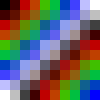

In [7]:
imresize(indexed_img; ratio=2) # no longer an IndirectArray

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*